# TITANIC ANALYSIS

# 0. Contextualization

Project built to participate at Titanic Kaggle competition. Problem description and goal are explained [here](https://www.kaggle.com/c/titanic/overview/description).

**Highlights:**

- 2224 people on board

- 722 people survived (32%)

- Survival rates among classes: first (61%); second(42%); and third (24%)

- 20% male survived against 75% female

- The Titanic was in Southampton, Cherbourg Harbour and Queenstown before heading to NY

- Captain Smith ordered the lifeboats to be loaded under the orders women and children first

- When the body of Saloon Steward Herbert Cave was recovered, among his effects was found a partial listing of first class passengers. It is [the only documentary evidence](https://web.archive.org/web/20130915143037/http://www.encyclopedia-titanica.org/cave-list.html) of cabin allocations on the Titanic.

# 1. Collection

Kaggle data only requires to be downloaded and imported.

*To add value:* collect data from a webpage with a list of people on board and their survival. It requires to scrap data, clean it and match it with the test dataset. Nowadays, to look for their survival, it is better to collect it directly than building a predictive model.

**IMPORTANT :** looking up the answers defeats the entire purpose of the competition. Do not present these results on Kaggle. This should be done for fun and to learn basic scrapping techniques.

## Libraries

In [4]:
# I/O files
import pandas as pd

# Scraping
import requests
from bs4 import BeautifulSoup

## Functions

In [61]:
# def get_tables(url,file_name):
#     '''
#     It creates a csv file with the headers of the first table appearing at the webpage and all the rows of the different table.
    
#     Required libraries are: requests; pandas; BeautifulSoup from bs4
#     '''

# # Obtain the html text and obtain all the tables
#     r = requests.get(url)
#     soup = BeautifulSoup(r.text, 'html.parser')
#     tables = soup.find_all('table')

# # From the first table, get the headers
#     headers = []
#     for th in tables[0].find('tr').find_all('td'):
#         headers.append(th.text)

# # From all of the tables, get the rows
#     rows = []
#     for num_tab in range(len(tables)):
#         for tr in tables[num_tab].find_all('tr')[1:]:
#             cells = []
#             for tc in tr.find_all('td'):
#                 cells.append(tc.text)
#             rows.append(cells)

# # Save the table into a csv
#     pd.DataFrame(rows, columns=headers).to_csv(f"{file_name}.csv", index=False) 

## Code

In [5]:
# We import the train and test dataset from the csv files obtained in Kaggle
train_data = pd.read_csv("titanic_train.csv")
test_data = pd.read_csv("titanic_test.csv")

In [62]:
# url1 = 'https://titanicfacts.net/titanic-survivors-list/'
# url0 = 'https://titanicfacts.net/titanic-casualties-list/'

# get_tables(url1,'survivors')
# get_tables(url0,'casualties')
        
survivors = pd.read_csv('survivors.csv')
casualties = pd.read_csv('casualties.csv')

# 2. Cleaning

## Libraries

In [6]:
#Algebra
import numpy as np 

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## General idea of the datasets

##### Columns and rows

In [13]:
print('Train:\t',train_data.shape)
print('Test:\t',test_data.shape)

Train:	 (891, 12)
Test:	 (418, 11)


##### General view 

In [15]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [14]:
test_data.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


**Observations**:

- Test dataset 50% shorter
- 12 features
- 'Cabin' possesses a great number of nulls
- 'Age' seems to have a few nulls
- Features composed by strings may contain errors or typos. Specially the Name and Sex feature
- PassengerId seems unuseful. **May be drop**
- Name could be related with etny or a title (appears after the comma: Mr., Mrs., Master., Sir...)
- Tickets are alphanumerical and difficult to understand

##### Features

In [18]:
# train_data.dtypes

| Feature | Definition | Variable | Datatype |
| :-- | :-- | :-- | :-- |
| PassengerId | identification number | - | int64 |
| Survived | whether the person survived (1) or not (0) | Categorical | int64 |
| Pclass | passenger class | Ordinal | int64
| Name | complete name of the passenger | - | object |
| Sex | sex of the passenger | Categorical | object |
| Age | age of each passenger | Continuous | float64 |
| SibSp | number of siblings and spouses | Discrete | int64 |
| Parch | number of parents and children | Discrete | int64 |
| Ticket | ticket's code | Alphanumerical | object |
| Fare | quantity paid in  | Continuous | float64 |
| Cabin | cabin where they stayed | Alphanumerical | object |
| Embarked | embarked port | Categorical | object |


##### Nulls

In [19]:
# We can also use train_data.info()
for col in test_data.columns.values:
    print(col[0:6],'\t',100*test_data[col].isna().sum()/len(test_data[col]))

Passen 	 0.0
Pclass 	 0.0
Name 	 0.0
Sex 	 0.0
Age 	 20.574162679425836
SibSp 	 0.0
Parch 	 0.0
Ticket 	 0.0
Fare 	 0.23923444976076555
Cabin 	 78.22966507177034
Embark 	 0.0


**Observations:**

- Ages has around 20% of missing values
- Cabin surpasses 75% threshold of missing values
- Embarked and Fare features have less than the 0.24%


- The only documentary evidence of cabin allocations was a partial listing of first class passengers. Therefore, it is justified the high number of missed values cabins. Besides, it may relate to first class passengers.
- The cabin's code seems to be unnecessary. It may be better to convert it into a boolean variable.
- Age feature has a high chance to be related with survival rate. It is worthy to fill the nulls.

## First cleaning

**First conclusions**
- PassengerId do not provide any useful information and it is irrelevant. **Drop**
- Although name could be an interesting option to analyze etnicity, it seems rather difficult when compared with the possible results. Also, the power distinction of social status seems to be better represented by the class. **Drop**
- The cabin name itself does not seem to have any relevance when compared to the fact that the cabin name is recorded. Therefore it is better to convert it to a boolean variable where 0 stands for no cabin recorded. **Convert**

In [36]:
# train_data = train_data.drop(['PassengerId', 'Name'], axis=1)
test_data = test_data.drop(['PassengerId', 'Name'], axis=1)

In [34]:
# for counter, value in enumerate(train_data.Cabin.isna()):
#    train_data.Cabin[counter] = 0 if value else 1
# for counter, value in enumerate(test_data.Cabin.isna()):
#    test_data.Cabin[counter] = 0 if value else 1

<ipython-input-34-9e220d885709>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.Cabin[counter] = 0 if value else 1


In [37]:
test_data.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,male,34.5,0,0,330911,7.8292,0,Q
1,3,female,47.0,1,0,363272,7.0000,0,S
2,2,male,62.0,0,0,240276,9.6875,0,Q
3,3,male,27.0,0,0,315154,8.6625,0,S
4,3,female,22.0,1,1,3101298,12.2875,0,S


## Deep understanding of the datasets

##### Percentages and count_values

##### Outliers

##### Distributions

**Observations:**
- A family feature to group SibSp and Parch
- Substitute age missing values with the mean
- Substitute Fare missing values with the median
- Substitute Embarked values with S

### Numerical data

In [117]:
for col in ['Survived','Pclass','Sex','SibSp','Parch','Embarked']:
    print(train_data[col].value_counts())

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
8.4583      1
9.8375      1
8.3625      1
14.1083     1
17.4000     1
Name: Fare, Length: 248, dtype: int64


C:\Users\david\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\david\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<function matplotlib.pyplot.show(*args, **kw)>

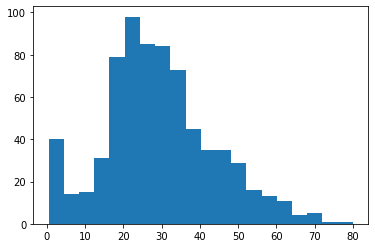

In [124]:
plt.hist(train_data['Age'], bins=20)
plt.show

In [40]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [104]:
#test_data.describe()

Comparing the numerical values from each dataset, we find similar means and standard deviations of the Pclass, Age, SibSp, Parch and Fare. We do not find any outlier or irregular value by lookin ath the min and max evaluation.

It is true however, that are

In [103]:
train_data.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Baclini, Miss. Eugenie",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


In [4]:
print(train_data.Sex.value_counts())
print(train_data.Embarked.value_counts())
print(644/889)

male      577
female    314
Name: Sex, dtype: int64
S    644
C    168
Q     77
Name: Embarked, dtype: int64
0.7244094488188977


3    491
1    216
2    184
Name: Pclass, dtype: int64

- Cabin: almost 28% of the cabins available are shared.
- Ticket: 23.6% of the tickets are repeated.
- Sex: 64.75% of the passengers are male.
- Name: there is no name repeated.
- Embarked: a 72.44% of the passengers take the ship at the Southhoumpon port.

### Analyze by pivoting features

In [37]:
train_data[["Pclass", "Survived"]].groupby(['Pclass']).mean().sort_values(by='Survived', ascending=False)

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [38]:
train_data[['Sex', 'Survived']].groupby(['Sex']).mean().sort_values(by='Survived', ascending=False)

,Survived
Sex,
female,0.742038
male,0.188908


In [39]:
train_data[['SibSp', 'Survived']].groupby(['SibSp']).mean().sort_values(by='Survived', ascending=False)

,Survived
SibSp,
1,0.535885
2,0.464286
0,0.345395
3,0.250000
4,0.166667
5,0.000000
8,0.000000


In [40]:
train_data[['Parch', 'Survived']].groupby(['Parch']).mean().sort_values(by='Survived', ascending=False)

,Survived
Parch,
3,0.600000
1,0.550847
2,0.500000
0,0.343658
5,0.200000
4,0.000000
6,0.000000


### Analyze by visualazing

In [ ]:
plt.hist(df)
plt.title(feature)
plt.show()

In [ ]:
pd.pivot_table(train_data, index='Survived', values=['','',''])

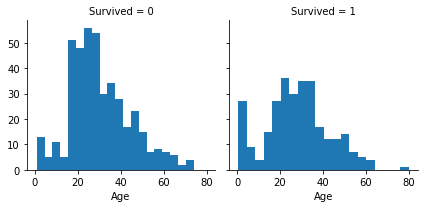

In [41]:
g = sns.FacetGrid(train_data, col='Survived')
g.map(plt.hist, 'Age', bins=20)

# 3. EDA

### Explore a pattern
Remember that the sample submission file in gender_submission.csv assumes that all female passengers survived (and all male passengers died).

In [44]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


In [7]:
men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


The code above calculates the percentage of male passengers (in train.csv) who survived.

From this you can see that almost 75% of the women on board survived, whereas only 19% of the men lived to tell about it. Since gender seems to be such a strong indicator of survival, the submission file in gender_submission.csv is not a bad first guess, and it makes sense that it performed reasonably well!

# 4. APPLY ML
We'll build a random forest model. This model is constructed of several "trees" (there are three trees in the picture below, but we'll construct 100!) that will individually consider each passenger's data and vote on whether the individual survived. Then, the random forest model makes a democratic decision: the outcome with the most votes wins!

The code cell below looks for patterns in four different columns ("Pclass", "Sex", "SibSp", and "Parch") of the data. It constructs the trees in the random forest model based on patterns in the train.csv file, before generating predictions for the passengers in test.csv. The code also saves these new predictions in a CSV file my_submission.csv.

Copy this code into your notebook, and run it in a new code cell.

In [8]:
from sklearn.ensemble import RandomForestClassifier

y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)

Your submission was successfully saved!


Make sure that your notebook outputs the same message above (Your submission was successfully saved!) before moving on.

    Again, don't worry if this code doesn't make sense to you! For now, we'll focus on how to generate and submit predictions.

Once you're ready, click on the blue "Save Version" button in the top right corner of your notebook. This will generate a pop-up window.

- Ensure that the "Save and Run All" option is selected, and then click on the blue "Save" button.
- This generates a window in the bottom left corner of the notebook. After it has finished running, click on the number to the right of the "Save Version" button. This pulls up a list of versions on the right of the screen. Click on the ellipsis (...) to the right of the most recent version, and select Open in Viewer.
- Click on the Output tab on the right of the screen. Then, click on the "Submit to Competition" button to submit your results.

In [ ]:
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier